## Robust optimization - example with szenario analysis
In the standard case, the optimization takes all information (such as prices) for granted and finds the optimum that maximizes the DCF. In reality, particularly prices are uncertain. One way to take into account uncertainty is to minimize risk and maximize the minimum portfolio performance.

In this sample we demonstrate robust optimization for a simple portfolio with a storage as the main asset -- where we have a small set of different szenarios. Those szenarios do not necessarily come from a distribution, they would more likely reflect distinct szenarios of a future development (e.g. a regulation is put in place vs. is not put in place).

Note: This optimization approach assumes the asset cannot be re-optimized e.g. once new information during the time frame optimized is available.

## Some prerequisites

In [12]:
import numpy as np
import pandas as pd
import datetime as dt
import os, sys
from IPython.display import display, HTML
import eaopack as eao

### Load data from JSON
For simplicity we use a predefined (simple) portfolio. Note that eao provides a simple (de-)serialization from and to JSON files. This allows you to define and store simgle assets or portfolios

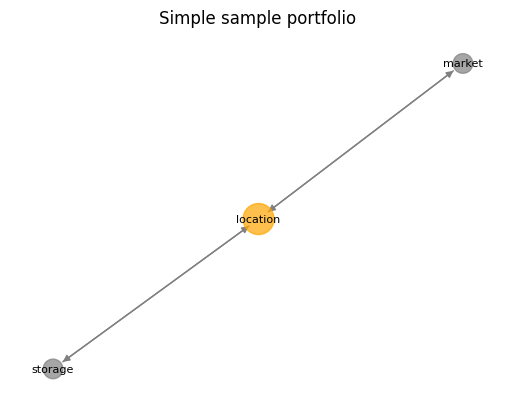

In [13]:
# define file names for this sample
## input data
sample_file   = 'portfolio_robust_optimization.json'
timegrid_file = 'timegrid.json'
portf = eao.serialization.load_from_json(file_name= sample_file)
timegrid = eao.serialization.load_from_json(file_name=timegrid_file)
eao.network_graphs.create_graph(portf = portf,title = 'Simple sample portfolio')

## Define price samples
Each contract comes with its own price. In this example we keep two price series fixed (for fix price sales contracts) and sample the floating price (sourcing). Note that the storage is the main element that requires robust optimization. In a deterministic case, it is steered hard to a specific price vector. In the robust case it takes into account prices are uncertain.

In [14]:
price_samples = []
# szenario 1
ts = 5+4*np.sin(np.linspace(0.,15., timegrid.T)) 
price_samples.append({'price': ts})
# szenario 2
ts = 5+5*np.sin(3.+np.linspace(0.,15., timegrid.T)) 
price_samples.append({'price': ts})
# szenario 3
ts = 5+3*np.sin(1+np.linspace(0.,12., timegrid.T)) 
price_samples.append({'price': ts})
# mean price - to provide an alternative optimization target
mean_prices = {}
for myp in price_samples[0]:
    ts = 0.
    for i, ps in enumerate(price_samples):
        ts += ps[myp]
    ts /= len(price_samples)
    mean_prices[myp] = ts

## Running the optimization
### (1) deterministic optimization on the mean price

In [15]:
op_mean  = portf.setup_optim_problem(mean_prices, timegrid)
res_mean = op_mean.optimize()

### (2) robust optimization on the whole set of prices
In the implementation we re-use the optimization problem with all its restrictions and add the samples. For this purpose, the price samples need to be translated to specific cost arrays for each asset in the portfolio.

In [16]:
cost_samples = portf.create_cost_samples(price_samples = price_samples, timegrid = timegrid)
res_robust  = op_mean.optimize(target = 'robust', samples = cost_samples)

## Analysis

### Portfolio value
Looking at the plain portfolio value, it is not surprising, that the robust optimization achieves less value on the mean price, than the optimization that is optimized directly on the mean

In [17]:
print('Portfolio value against mean prices:')
print('... optimized against mean: ' + '{:10.1f}'.format(res_mean.value))
print('... robust optimization   : ' + '{:10.1f}'.format(res_robust.value))

Portfolio value against mean prices:
... optimized against mean:      359.2
... robust optimization   :      118.3


Now let us look at the performance of the optimized portfolios against price samples.

In [18]:
values_mean   = np.empty(len(price_samples))
values_robust = np.empty(len(price_samples))
for i, myc in enumerate(cost_samples):
    values_mean[i] = -sum(res_mean.x*myc)
    values_robust[i] = -sum(res_robust.x*myc)
print('Minimum portfolio value on original samples:')
print('... optimized against mean: ' + '{:10.1f}'.format(values_mean.min()))
print('... robust optimization   : ' + '{:10.1f}'.format(values_robust.min()))    


Minimum portfolio value on original samples:
... optimized against mean:    -2018.6
... robust optimization   :      118.3


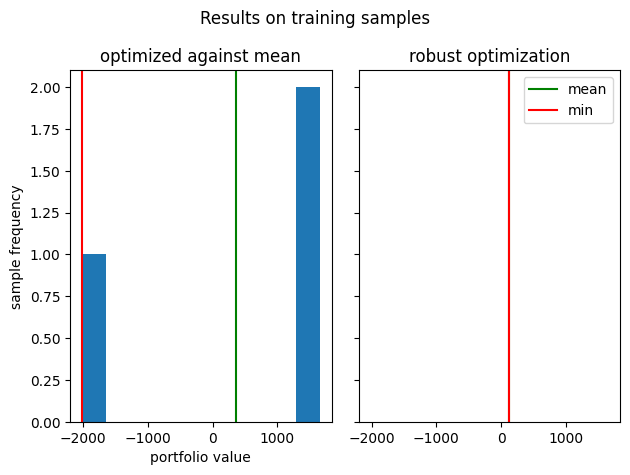

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
n_bins = 10
fig, ax = plt.subplots(1,2, sharey = True, sharex = True, tight_layout = True)
fig.suptitle('Results on training samples')
ax[0].hist(values_mean, bins = n_bins)
ax[1].hist(values_robust, bins = n_bins)
ax[0].set_xlabel('portfolio value')
ax[0].set_ylabel('sample frequency')
ax[0].set_title('optimized against mean')
ax[1].set_title('robust optimization')
ax[0].axvline(x = values_mean.mean(), c = 'g', label = 'mean')
ax[1].axvline(x = values_robust.mean(), c = 'g', label = 'mean')
ax[0].axvline(x = values_mean.min(), c = 'r', label = 'min')
ax[1].axvline(x = values_robust.min(), c = 'r', label = 'min')
ax[1].legend()
plt.show()


### Detailed view
Let us look at prices and the dispatch

In [20]:
out_mean   = eao.io.extract_output(portf, op_mean, res_mean , mean_prices)
out_robust = eao.io.extract_output(portf, op_mean, res_robust , mean_prices)

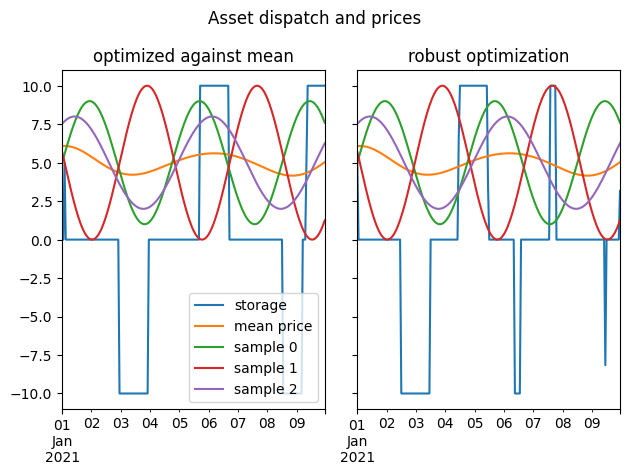

In [21]:
fig, ax = plt.subplots(1,2, sharey = True, sharex = True, tight_layout = True)
fig.suptitle('Asset dispatch and prices')
# add price info to dispatches
out_mean['dispatch']['mean price'] = mean_prices['price']
out_robust['dispatch']['mean price'] = mean_prices['price']
out_robust['dispatch'].drop(['market'], axis = 1, inplace=True)
out_mean['dispatch'].drop(['market'], axis = 1, inplace=True)
for i, ps in enumerate(price_samples):
    out_robust['dispatch']['sample '+str(i)] = ps['price']
    out_mean['dispatch']['sample '+str(i)] = ps['price']
out_mean['dispatch'].plot(kind='line', ax = ax[0])
out_robust['dispatch'].plot(kind='line', ax = ax[1], legend = None)
ax[0].set_title('optimized against mean')
ax[1].set_title('robust optimization')
#ax[0].axis('off')
#ax[1].axis('off')
plt.show()


This illustrates the approach (being a very simple example): The dispatch optimized against the mean exploits ups and downs in the mean of prices. However, due to the design of the szenarios, this optimum may prove a very bad fit for some szenarios. The robust optimization maximizes against all single szenarios jointly using a MaxiMin target.